## Alternus Vera - PART 2 
### Factor - Sensationalism

##### Author: Anjana Eldo
##### SJSU ID : 012488983

#### Team Psychic Pandas
#### We have decided to work on the following four factors:
* Sensationalism
* Topic Features
* Controversy
* Political affiliation/partisan bias


In [203]:
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
import json
import re

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder
from collections import Counter

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

import nltk, string

#### Importing Data from files

In [204]:
DATA_FOLDER = '/Users/andrew/Documents/MS - SJSU/Fall Sem 2018/CMPE 257 - Machine Learning/liar_dataset'
TRAIN_PATH = '/train.tsv'
TEST_PATH = '/test.tsv'
train_df_1 = pd.read_csv(DATA_FOLDER+TRAIN_PATH,sep='\t', header = None)
test_df = pd.read_csv(DATA_FOLDER+TEST_PATH,sep='\t', header = None)

#### Adding column headings

In [205]:
train_df_1.columns = ["id", "label", "statement", "subject", "speaker", "speaker_title", "State", "party_affiliation", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire","context"]
test_df.columns = ["id", "label", "statement", "subject", "speaker", "speaker_title", "State", "party_affiliation", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire","context"]


#### Studying the data distribution and visualizations of words in the dataset

In [206]:
train_df_1.label.value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64

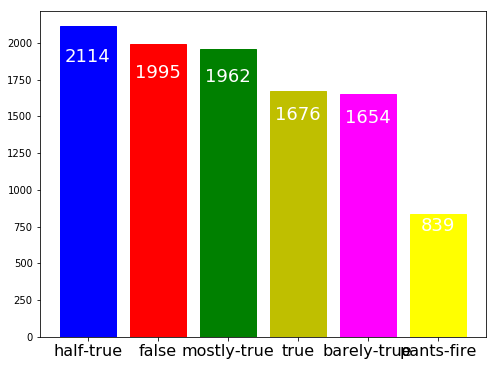

In [207]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

news_label = train_df_1.label.value_counts()

ax.bar(range(6), news_label)
ax.set_xticks(range(6))
ax.set_xticklabels(news_label.index, fontsize=16)

for rect, c, value in zip(ax.patches, ['b', 'r', 'g','y','magenta','yellow'], news_label.values):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=18, color='white')

### Inspect the number of words in the statement

* It is important to know the number of words in the document to see how good LDA result would be.

In [208]:
document_lengths = np.array(list(map(len, train_df_1.statement.str.split(' '))))

In [209]:
print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 17.9701171875.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 302.


* As we can see there is a document with just 2 words.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


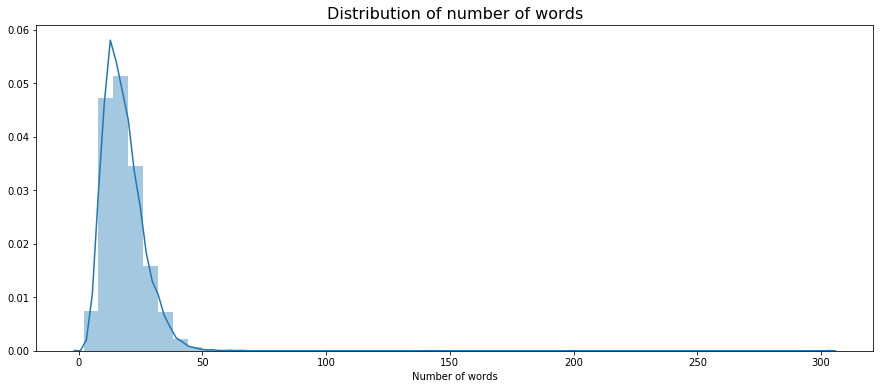

In [210]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

* There are very few documents with words more than 50.So lets see the documents with fewer words.

In [211]:
print("There are {} documents with over 50 words.".format(sum(document_lengths > 50)))

shorter_documents = document_lengths[document_lengths <= 50]

There are 19 documents with over 50 words.


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


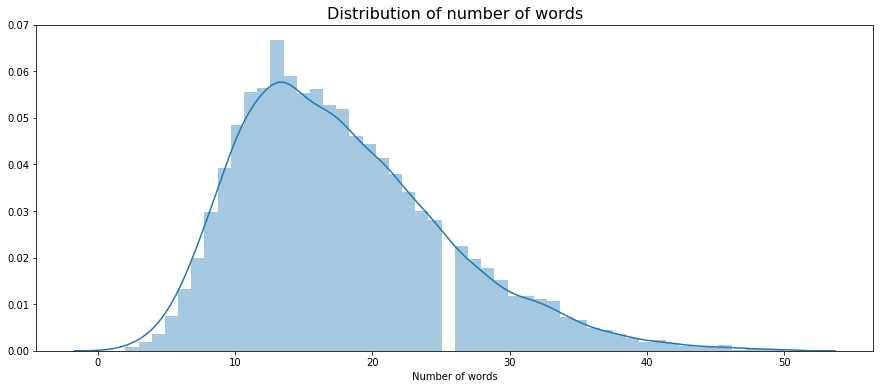

In [212]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

* Documents with less number of words will be difficult to classify.Lets look at what these documents are

In [213]:
print("There are {} documents with tops 5 words.".format(sum(document_lengths <= 5)))

There are 136 documents with tops 5 words.


In [214]:
train_df_1[document_lengths == 2]

,id,label,statement,subject,speaker,speaker_title,State,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context
709,5919.json,false,On abortion,"abortion,corrections-and-updates",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,various statements
1014,8882.json,half-true,On abortion,"abortion,candidates-biography",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,various statements
1071,630.json,true,On torture.,military,john-mccain,U.S. senator,Arizona,republican,31.0,39.0,31.0,37.0,8.0,NaN
2940,1552.json,false,On reconciliation,"bipartisanship,health-care,legal-issues",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,campaign speeches
6131,4493.json,false,Were bankrupt.,"economy,federal-budget",gary-johnson,Presidential candidate,New Mexico,libertarian,3.0,2.0,5.0,6.0,0.0,"a Republican presidential debate in Orlando, Fla."
6527,4297.json,false,On abortion.,abortion,susan-combs,State comptroller,Texas,republican,0.0,1.0,0.0,0.0,1.0,an interview
6759,995.json,half-true,On torture.,"human-rights,terrorism",newt-gingrich,"Co-host on CNN's ""Crossfire""",Georgia,republican,16.0,15.0,20.0,10.0,11.0,a news interview
7638,6862.json,false,On sequestration,"debt,federal-budget",eric-cantor,House Majority Leader,Virginia,republican,9.0,6.0,4.0,4.0,4.0,a debate.


* Though there are documents with few words they are meaningful and can be used to create an LDA model.

#### Documents with length 3

In [215]:
train_df_1[document_lengths == 3]

,id,label,statement,subject,speaker,speaker_title,State,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context
470,12499.json,pants-fire,Crime is rising.,"crime,criminal-justice",donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,a speech after several primaries concluded
1027,10954.json,false,On same-sex marriage.,"gays-and-lesbians,marriage",hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a video with the Human Rights Campaign.
1178,12029.json,half-true,NASCAR endorsed Trump,"candidates-biography,sports",donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,"a speech in Concord, N.C."
2202,4280.json,false,The countrys bankrupt.,"bankruptcy,deficit,federal-budget",ron-paul,U.S. representative,Texas,republican,5.0,8.0,8.0,8.0,3.0,"in a debate in Ames, Iowa"
2274,8086.json,mostly-true,I was filibustered.,"bipartisanship,congressional-rules",rob-portman,U.S. senator from Ohio,Ohio,republican,3.0,5.0,11.0,11.0,1.0,a news conference call
3481,3263.json,false,On high-speed rail.,"corrections-and-updates,stimulus,transportation",mike-haridopolos,Florida Senate President,Florida,republican,0.0,3.0,1.0,1.0,0.0,a press statement.
3520,1404.json,half-true,On abortion rights.,abortion,harold-ford-jr,NaN,NaN,democrat,0.0,0.0,0.0,0.0,0.0,comments on the subject over the past 10 years.
3623,12175.json,half-true,Weve rebuilt China.,"china,foreign-policy,trade",donald-trump,President-Elect,New York,republican,63.0,114.0,51.0,37.0,61.0,an interview with the New York Times
4291,7228.json,false,On same-sex marriage,"civil-rights,gays-and-lesbians,marriage",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,NaN
4454,5981.json,half-true,On transportation financing,"state-budget,transportation",chris-christie,Governor of New Jersey,New Jersey,republican,10.0,17.0,27.0,19.0,8.0,an Assembly Budget Committee hearing


## Data Prepocessing  - for LDA and word2vec model

In [216]:
our_special_word = 'qwerty'
def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'statement'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'statement'] = df.loc[i, 'statement'].replace(word, our_special_word)
    return non_ascii_words

non_ascii_words = remove_ascii_words(train_df_1)

print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
    len(non_ascii_words)))

Replaced 6 words with characters with an ordinal >= 128 in the train data.


In [217]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [218]:
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['statement'] = df.statement.str.lower()
    df['document_sentences'] = df.statement.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(train_df_1)

In [219]:
def lda_get_good_tokens(df):
    df['statement'] = df.statement.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.statement))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(train_df_1)

In [220]:
tokenized_only_dict = Counter(np.concatenate(train_df_1.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [221]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

#### Depending on the frequency of the occurance of words a graph is plotted to understand the distribution of how often words occur

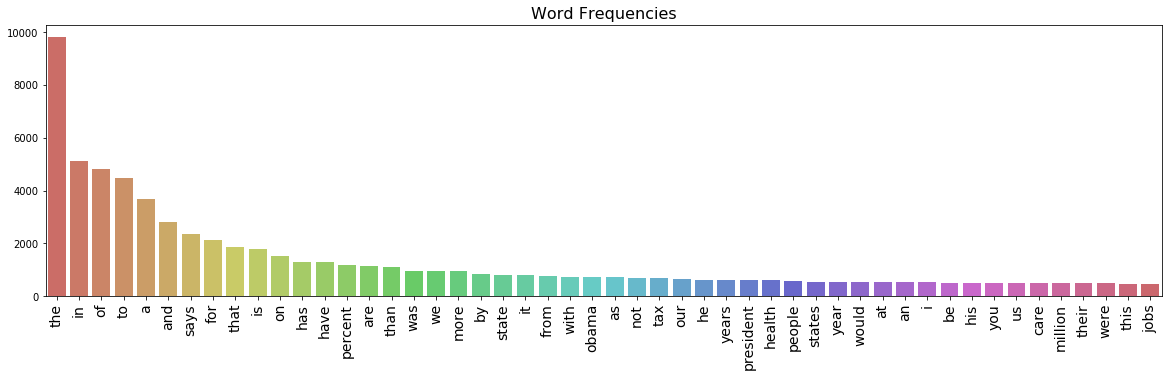

In [222]:
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16);

* As its seen from the grapgh there are lot of stopwords that occur.This has to be removed

In [223]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(train_df_1)

In [224]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(train_df_1)

In [225]:
dictionary = Dictionary(documents=train_df_1.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 9389 words.


In [226]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 3859 words.


In [227]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(train_df_1)

In [228]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [229]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

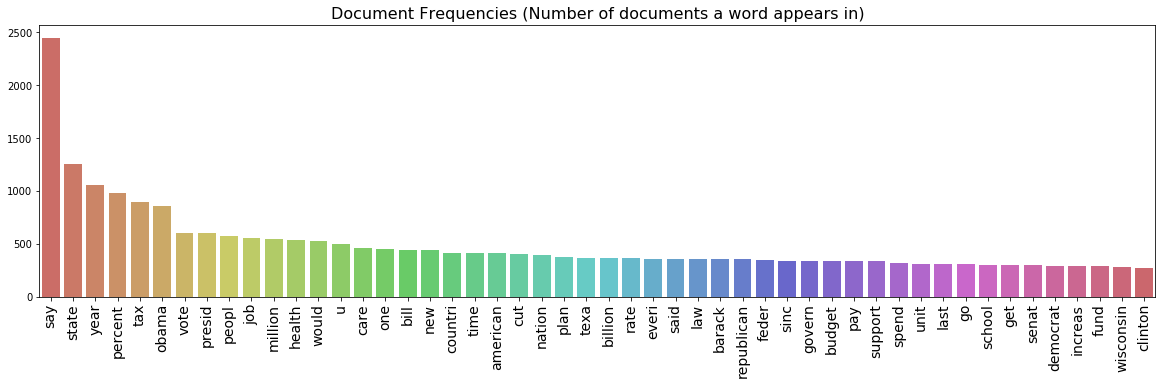

In [230]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [231]:
half_true_words = list(np.concatenate(train_df_1.loc[train_df_1.label == 'half-true', 'stemmed_text'].values))
false_words = list(np.concatenate(train_df_1.loc[train_df_1.label == 'false', 'stemmed_text'].values))
mostly_true_words = list(np.concatenate(train_df_1.loc[train_df_1.label == 'mostly-true', 'stemmed_text'].values))
true_words = list(np.concatenate(train_df_1.loc[train_df_1.label == 'true', 'stemmed_text'].values))
barely_true_words = list(np.concatenate(train_df_1.loc[train_df_1.label == 'barely-true', 'stemmed_text'].values))
pants_fire_words = list(np.concatenate(train_df_1.loc[train_df_1.label == 'pants-fire', 'stemmed_text'].values))

In [232]:
half_true_frequencies = {word: half_true_words.count(word) for word in cleansed_words_df.index[:50]}
false_frequencies = {word: false_words.count(word) for word in cleansed_words_df.index[:50]}
mostly_true_frequencies = {word: mostly_true_words.count(word) for word in cleansed_words_df.index[:50]}
true_frequencies = {word: true_words.count(word) for word in cleansed_words_df.index[:50]}
barely_true_frequencies = {word: barely_true_words.count(word) for word in cleansed_words_df.index[:50]}
pants_fire_frequencies = {word: pants_fire_words.count(word) for word in cleansed_words_df.index[:50]}


In [233]:
frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:50])

In [234]:
frequencies_df['half_true_freq'] = list(map(lambda word:
                                      half_true_frequencies[word],
                                      frequencies_df.index))
frequencies_df['half_true_false_freq'] = list(map(lambda word:
                                          half_true_frequencies[word] + false_frequencies[word],
                                          frequencies_df.index))
frequencies_df['half_true_false_mostly_true_freq'] = list(map(lambda word:
                                              half_true_frequencies[word] + false_frequencies[word] + mostly_true_frequencies[word],
                                              frequencies_df.index))
frequencies_df['half_true_false_mostly_true_true_freq'] = list(map(lambda word:
                                              half_true_frequencies[word] + false_frequencies[word] + mostly_true_frequencies[word]
                                                                   +true_frequencies[word],
                                              frequencies_df.index))
frequencies_df['half_true_false_mostly_true_true__barely_true_freq'] = list(map(lambda word:
                                              half_true_frequencies[word] + false_frequencies[word] + mostly_true_frequencies[word]
                                                                   +true_frequencies[word]+barely_true_frequencies[word],
                                              frequencies_df.index))

frequencies_df['half_true_false_mostly_true_true__barely_true_pants_fire_freq'] = list(map(lambda word:
                                              half_true_frequencies[word] + false_frequencies[word] + mostly_true_frequencies[word]
                                                                   +true_frequencies[word]+barely_true_frequencies[word]+pants_fire_frequencies[word],
                                              frequencies_df.index))

* The distribution of articles baseed on the label whether it is true or false and which words contribute to detecting that factor can visualized from the below graph.

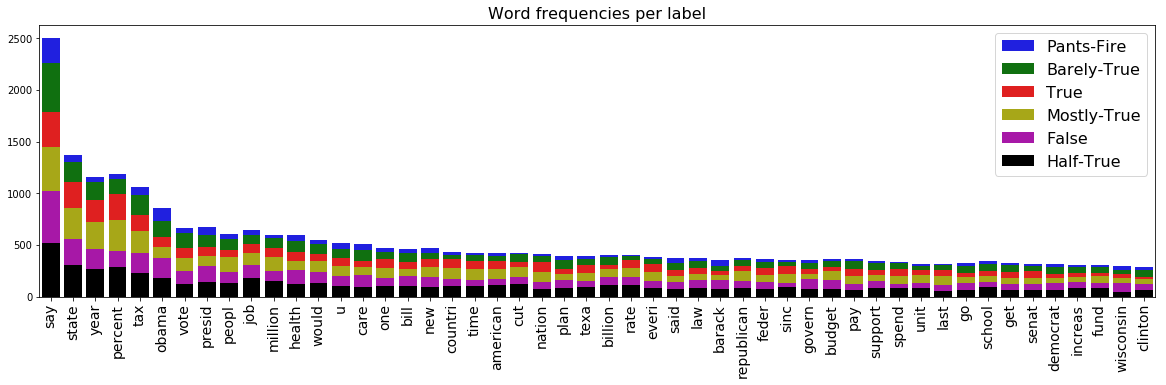

In [235]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['half_true_false_mostly_true_true__barely_true_pants_fire_freq'].values, color='b', ax=ax, label="Pants-Fire")
sns.barplot(nrs, frequencies_df['half_true_false_mostly_true_true__barely_true_freq'].values, color='g', ax=ax, label="Barely-True")
sns.barplot(nrs, frequencies_df['half_true_false_mostly_true_true_freq'].values, color='r', ax=ax, label="True")
sns.barplot(nrs, frequencies_df['half_true_false_mostly_true_freq'].values, color='y', ax=ax, label="Mostly-True")
sns.barplot(nrs, frequencies_df['half_true_false_freq'].values, color='m', ax=ax, label="False")
sns.barplot(nrs, frequencies_df['half_true_freq'].values, color='black', ax=ax, label="Half-True")

ax.set_title("Word frequencies per label", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

### Creation of My Vocabulary

My vocabulay is a combination of words derived from various internet sources and by combining the words from the train dataset which resutls in fake and pants on fire news.

In [236]:
sensational_words_addition = pd.read_csv('/Users/andrew/Documents/MS - SJSU/Fall Sem 2018/CMPE 257 - Machine Learning/liar_dataset/sensational_words.csv')
sensational_words_from_train = pd.read_csv('/Users/andrew/Documents/MS - SJSU/Fall Sem 2018/CMPE 257 - Machine Learning/liar_dataset/sensational_words_from_train.csv')
                                                    

In [237]:

sensational_words_addition['Phrases'].replace('', np.nan, inplace=True)
sensational_words_from_train['Phrases'].replace('', np.nan, inplace=True)

In [238]:
sensational_words_addition = sensational_words_addition['Phrases'].dropna()
sensational_words_from_train= sensational_words_from_train['Phrases'].dropna()

In [239]:
frames = [sensational_words_addition, sensational_words_from_train]
sensational_words = pd.concat(frames)

In [240]:
sensational_words

0              Assassination
1                     Attack
2          Domestic security
3            Law enforcement
4                   Disaster
5      National preparedness
6                   Response
7                   Recovery
8         Emergency response
9            First responder
10                   Militia
11                  Shooting
12                Evacuation
13                   Hostage
14                 Explosion
15           Organized crime
16                     Gangs
17         National security
18        State of emergency
19           Security breach
20                    Threat
21                  Standoff
22                  Lockdown
23                      Bomb
24                      Riot
25         Emergency Landing
26                  Incident
27                Suspicious
28            Nuclear threat
29                 Hazardous
               ...          
146               nomination
147                  machine
148                 finances
149           

#### Data Preprocessing
* Next step is to prepare the data by removing all punctuations,stopwords etc
* At first, tokenization is applied to split the text we have just got to sentences and then sentences to words.
* Next, it is converted to lowercase
* Then Lemmatization is applied to change all past and future words to present and also changes words with third person to first
* Next step os to apply Stemming whre words are changed to their root form

* For preprocessing, genism library is imported.

### Function to carry out lemmetization and stemming

In [241]:
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

### Processing all the articles in the set¶

In [242]:
se = pd.Series(sensational_words)

In [243]:
processed_statement = se.map(preprocess)
processed_statement[:5]

0         [assassin]
1           [attack]
2    [domest, secur]
3           [enforc]
4           [disast]
Name: Phrases, dtype: object

In [244]:
dictionary = gensim.corpora.Dictionary(processed_statement)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 assassin
1 attack
2 domest
3 secur
4 enforc
5 disast
6 nation
7 prepared
8 respons
9 recoveri
10 emerg


### Bags of words on the processed dataset

* Creating a dictionary of words from the processed data that we got above

### Using bow2Vec

In [245]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_statement]
bow_corpus[5]

[(6, 1), (7, 1)]

In [246]:
bow_doc_5 = bow_corpus[5]
for i in range(len(bow_doc_5)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_5[i][0], 
                                               dictionary[bow_doc_5[i][0]], 
bow_doc_5[i][1]))

Word 6 ("nation") appears 1 time.
Word 7 ("prepared") appears 1 time.


### Applying TF-IDF to bow_corpus

In [247]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 1.0)]


### Applying LDA to bow_corpus
* LDA model has been trained with the processed statements from the dataset and my vocabulary

In [248]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=4, id2word=dictionary, passes=2, workers=2)

### Applying LDA for Bag Of Words¶

In [249]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.015*"crime" + 0.015*"islam" + 0.010*"market" + 0.010*"organ" + 0.010*"stock" + 0.010*"report" + 0.010*"enforc" + 0.010*"food" + 0.010*"veteran" + 0.010*"phish"
Topic: 1 
Words: 0.017*"suicid" + 0.017*"infrastructur" + 0.017*"explos" + 0.017*"state" + 0.017*"financ" + 0.017*"disast" + 0.015*"transport" + 0.010*"attack" + 0.010*"improvis" + 0.010*"devic"
Topic: 2 
Words: 0.037*"terror" + 0.036*"secur" + 0.023*"nation" + 0.016*"cyber" + 0.016*"weather" + 0.016*"drug" + 0.016*"respons" + 0.016*"shoot" + 0.016*"price" + 0.009*"infrastructur"
Topic: 3 
Words: 0.025*"emerg" + 0.021*"nuclear" + 0.016*"attack" + 0.016*"threat" + 0.016*"chang" + 0.016*"climat" + 0.016*"lotteri" + 0.014*"servic" + 0.009*"denial" + 0.009*"state"


### Applying LDA on TF-IDF

In [250]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=4, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.027*"secur" + 0.022*"attack" + 0.015*"infrastructur" + 0.015*"threat" + 0.014*"nation" + 0.012*"cyber" + 0.010*"patriot" + 0.010*"worker" + 0.010*"retir" + 0.010*"famili"
Topic: 1 Word: 0.032*"terror" + 0.017*"state" + 0.017*"nuclear" + 0.017*"islam" + 0.017*"disast" + 0.017*"financ" + 0.017*"lotteri" + 0.014*"drug" + 0.009*"respons" + 0.009*"lighten"
Topic: 2 Word: 0.016*"emerg" + 0.014*"climat" + 0.014*"chang" + 0.009*"crime" + 0.009*"tremor" + 0.009*"gambl" + 0.009*"incid" + 0.009*"recoveri" + 0.009*"gun" + 0.009*"hampshir"
Topic: 3 Word: 0.017*"price" + 0.017*"shoot" + 0.010*"servic" + 0.010*"outbreak" + 0.010*"sotomayor" + 0.010*"injur" + 0.010*"birth" + 0.010*"riot" + 0.010*"incom" + 0.010*"transpar"


### Passing the statement news to the LDA model

In [251]:
for index, score in sorted(lda_model[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.624447226524353	 
Topic: 0.017*"suicid" + 0.017*"infrastructur" + 0.017*"explos" + 0.017*"state" + 0.017*"financ" + 0.017*"disast" + 0.015*"transport" + 0.010*"attack" + 0.010*"improvis" + 0.010*"devic"

Score: 0.1251896619796753	 
Topic: 0.015*"crime" + 0.015*"islam" + 0.010*"market" + 0.010*"organ" + 0.010*"stock" + 0.010*"report" + 0.010*"enforc" + 0.010*"food" + 0.010*"veteran" + 0.010*"phish"

Score: 0.12518182396888733	 
Topic: 0.025*"emerg" + 0.021*"nuclear" + 0.016*"attack" + 0.016*"threat" + 0.016*"chang" + 0.016*"climat" + 0.016*"lotteri" + 0.014*"servic" + 0.009*"denial" + 0.009*"state"

Score: 0.12518127262592316	 
Topic: 0.037*"terror" + 0.036*"secur" + 0.023*"nation" + 0.016*"cyber" + 0.016*"weather" + 0.016*"drug" + 0.016*"respons" + 0.016*"shoot" + 0.016*"price" + 0.009*"infrastructur"


In [252]:
train_df_1['statement']= train_df_1['statement'].str.replace('\d+', '')
train_df_1['statement'] = train_df_1['statement'].replace('[^a-zA-Z0-9]', ' ', regex = True)

In [253]:
processed_statement = train_df_1['statement'].map(preprocess)

In [254]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_statement]

In [255]:
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [256]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=2, workers=2)

In [257]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.126*"state" + 0.095*"vote" + 0.047*"feder" + 0.045*"tax" + 0.043*"govern" + 0.041*"budget" + 0.033*"illeg" + 0.030*"public" + 0.028*"busi" + 0.023*"right"
Topic: 1 
Words: 0.110*"obama" + 0.079*"health" + 0.066*"care" + 0.048*"state" + 0.035*"support" + 0.031*"elect" + 0.028*"incom" + 0.028*"famili" + 0.026*"bush" + 0.025*"educ"
Topic: 2 
Words: 0.069*"job" + 0.059*"nation" + 0.053*"state" + 0.030*"medicar" + 0.029*"secur" + 0.028*"campaign" + 0.027*"congress" + 0.026*"counti" + 0.025*"social" + 0.023*"women"


In [258]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=3, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.023*"secur" + 0.021*"terror" + 0.018*"attack" + 0.016*"state" + 0.016*"nuclear" + 0.014*"infrastructur" + 0.014*"cyber" + 0.013*"disast" + 0.012*"financ" + 0.011*"transport"
Topic: 1 Word: 0.013*"shoot" + 0.012*"price" + 0.011*"lotteri" + 0.011*"respons" + 0.010*"explos" + 0.010*"emerg" + 0.008*"market" + 0.008*"homeland" + 0.008*"wealth" + 0.007*"penalti"
Topic: 2 Word: 0.013*"islam" + 0.011*"chang" + 0.011*"servic" + 0.009*"weather" + 0.008*"rule" + 0.008*"privaci" + 0.008*"congression" + 0.008*"economi" + 0.008*"sanctoin" + 0.008*"pundit"


In [259]:
for index, score in sorted(lda_model[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.4799346923828125	 
Topic: 0.126*"state" + 0.095*"vote" + 0.047*"feder" + 0.045*"tax" + 0.043*"govern" + 0.041*"budget" + 0.033*"illeg" + 0.030*"public" + 0.028*"busi" + 0.023*"right"

Score: 0.4514245390892029	 
Topic: 0.069*"job" + 0.059*"nation" + 0.053*"state" + 0.030*"medicar" + 0.029*"secur" + 0.028*"campaign" + 0.027*"congress" + 0.026*"counti" + 0.025*"social" + 0.023*"women"

Score: 0.06864073127508163	 
Topic: 0.110*"obama" + 0.079*"health" + 0.066*"care" + 0.048*"state" + 0.035*"support" + 0.031*"elect" + 0.028*"incom" + 0.028*"famili" + 0.026*"bush" + 0.025*"educ"


In [260]:
for index, score in sorted(lda_model_tfidf[bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.5459364652633667	 
Topic: 0.013*"islam" + 0.011*"chang" + 0.011*"servic" + 0.009*"weather" + 0.008*"rule" + 0.008*"privaci" + 0.008*"congression" + 0.008*"economi" + 0.008*"sanctoin" + 0.008*"pundit"

Score: 0.38622456789016724	 
Topic: 0.023*"secur" + 0.021*"terror" + 0.018*"attack" + 0.016*"state" + 0.016*"nuclear" + 0.014*"infrastructur" + 0.014*"cyber" + 0.013*"disast" + 0.012*"financ" + 0.011*"transport"

Score: 0.06783892214298248	 
Topic: 0.013*"shoot" + 0.012*"price" + 0.011*"lotteri" + 0.011*"respons" + 0.010*"explos" + 0.010*"emerg" + 0.008*"market" + 0.008*"homeland" + 0.008*"wealth" + 0.007*"penalti"


### Testing on an Unseen Document

In [261]:
unseen_document = 'Says he won the second debate with Hillary Clinton in a landslide in every poll.'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
score_list = []
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    score_list.append(score)
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5931183099746704	 Topic: 0.069*"job" + 0.059*"nation" + 0.053*"state" + 0.030*"medicar" + 0.029*"secur"
Score: 0.2930983006954193	 Topic: 0.110*"obama" + 0.079*"health" + 0.066*"care" + 0.048*"state" + 0.035*"support"
Score: 0.11378338187932968	 Topic: 0.126*"state" + 0.095*"vote" + 0.047*"feder" + 0.045*"tax" + 0.043*"govern"


#### Calculating the sensationalism percentage from forming an equation

In [262]:
#train_df_1['Sensationalism Percentage'] = None
#for i,row in train_df_1.iterrows():
    #if(i<1001):
       # print(i)
       # unseen_document = row['statement']
        #bow_vector = my_dictionary.doc2bow(preprocess(unseen_document))
        #score_list = []
        #for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
           # score_list.append(score)
        #score_final = (0.8)*score_list[0]+score_list[1];
        #print(score_final)
    ##print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
        #train_df_1['Sensationalism Percentage'][i] = score_final

In [87]:
#train_df_1.to_csv('train_enriched.csv', sep='\t')

#### Data Enrichement by adding sensationalism weightage to the dataset

In [263]:
train_data = pd.read_csv('train_enriched.csv',sep='\t', header = None)

In [264]:
train_data = train_data.iloc[1:]

In [265]:
train_data = train_data.drop(0,axis=1)

In [266]:
train_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0.624705570936203
2,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0.7123798400163651
3,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0.7493876576423646
4,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0.7832853734493256
5,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0.45
6,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,0.45
7,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.,0.45
8,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",0.6247754275798798
9,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,0.6247665584087372
10,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video,0.6247376292943955


In [352]:
train_data.columns = ["id", "label", "statement", "subject", "speaker", "speaker_title", "State", "party_affiliation", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire","context","Sensationalism_Percentage"]

In [353]:
train_data.head(5)

,id,label,statement,subject,speaker,speaker_title,State,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context,Sensationalism_Percentage
1,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0.624705570936203
2,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0.7123798400163651
3,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0.7493876576423646
4,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0.7832853734493256
5,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0.45


In [355]:
train_data_v1= train_data.head(1000)

#### Repeating the same steps for test_data

In [ ]:
#test_df['Sensationalism Percentage'] = None
#for i,row in test_df.iterrows():
    #if(i<1001):
        #print(i)
        #unseen_document = row['statement']
        #bow_vector = my_dictionary.doc2bow(preprocess(unseen_document))
        #score_list = []
        #for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
            #score_list.append(score)
        #score_final = score_final = (0.8)*score_list[0]+score_list[1];
        #print(score_final)
    #print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))
        #test_df['Sensationalism Percentage'][i] = score_final

In [ ]:
#test_df.to_csv('test_df_enriched_new.csv', sep='\t')

In [269]:
test_df_data = pd.read_csv('test_df_enriched_new.csv',sep='\t', header = None)

In [270]:
test_df_data = test_df_data.drop(0,axis=1)
test_df_data = test_df_data.iloc[1:]

In [271]:
test_df_data.columns = ["id", "label", "statement", "subject", "speaker", "speaker_title", "State", "party_affiliation", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire","context","Sensarionalism_percentage"]


In [491]:
test_df_v1 = test_df_data.head(1000)

#### Create a band of frequencies for label column in the dataset

* As a next step I wanted to build a classifier by training the model with Sensationalism percentage and the label it is assigned.
* For that I created a band of frequency that can be applied to the labels.
* For eg, pants - fire : I gave a random value between 1 and 0.833.
* I did this to get an equal distribution of weights for the label so that it can be comapred with the sensationalism_percentage
* If the sensationalism_percentage is above the threshold 0.5 it is more likely to be towards the false side of the news.
* If the news is less sensational it is more likely to be true.

In [492]:
import random
test_df_v1['label_encoded']=None

for i,row in test_df_v1.iterrows():
    print(i)
    if(row['label']=='pants-fire'):
        test_df_v1['label_encoded'][i] = random.uniform(0.833,1)#0.916
    elif(row['label']=='false'):
        test_df_v1['label_encoded'][i] = random.uniform(0.663,0.833)#0.75
    elif(row['label']=='barely-true'):
        test_df_v1['label_encoded'][i] = random.uniform(0.5,0.663)#0.58
    elif(row['label']=='half-true'):
        test_df_v1['label_encoded'][i] = random.uniform(0.332,0.5)#0.58 
    elif(row['label']=='mostly-true'):
        test_df_v1['label_encoded'][i] = random.uniform(0.166, 0.332)#0.75 
    elif(row['label']=='true'):
        test_df_v1['label_encoded'][i] = random.uniform(0, 0.166)#0.916 
    else:
        raise Exception('Invalid data!')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [357]:
train_data_v1['label_encoded']=None

for i,row in train_data_v1.iterrows():
        print(i)
        if(row['label']=='pants-fire'):
            train_data_v1['label_encoded'][i] = random.uniform(0.833,1)#0.916
        elif(row['label']=='false'):
            train_data_v1['label_encoded'][i] = random.uniform(0.663,0.833)#0.75
        elif(row['label']=='barely-true'):
            train_data_v1['label_encoded'][i] = random.uniform(0.5,0.663)#0.58
        elif(row['label']=='half-true'):
            train_data_v1['label_encoded'][i] = random.uniform(0.332,0.5)#0.58 
        elif(row['label']=='mostly-true'):
            train_data_v1['label_encoded'][i] = random.uniform(0.166, 0.332)#0.75 
        elif(row['label']=='true'):
            train_data_v1['label_encoded'][i] = random.uniform(0, 0.166)#0.916 
        else:
            raise Exception('Invalid data!')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


#### Applying TF_IDF and cosine similarity  

* Next I wanted to see how the documents are similar to the dictionary I have.
* So i calculated cosine similarity between the statements in the dataset with my dictionary.
* I formulated cosine similarity score for each statement and to which dictionary word it has the most similarity.
* Since the dictionary contains a set of sensational words, the presence of which word in the news would f=give more sensation could be found out.
* Thereby helping to determine whether the news incline more towards truth or false or fall in between

In [122]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [125]:
#tfidf_vectorizer = TfidfVectorizer(vocabulary=dictionary,use_idf=True,ngram_range=(1,3))

In [132]:
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]


In [148]:
sensational_words_list = list(sensational_words)

In [153]:
print (cosine_sim('attack', 'There was an attack and shooting at LA and 1000 people died'))

0.2789425453258252


In [178]:
for i,row in train_data.iterrows():
    print(row['statement'])

says the annies list political group supports third trimester abortions on demand 
when did the decline of coal start  it started when natural gas took off that started to begin in  president george w   bushs administration 
hillary clinton agrees with john mccain  by voting to give george bush the benefit of the doubt on iran  
health care reform legislation is likely to mandate free sex change surgeries 
the economic turnaround started at the end of my term 
the chicago bears have had more starting quarterbacks in the last  years than the total number of tenured  uw  faculty fired during the last two decades 
jim dunnam has not lived in the district he represents for years now 
i m the only person on this stage who has worked actively just last year passing  along with russ feingold  some of the toughest ethics reform since watergate 
however  it took    million in oregon lottery funds for the port of newport to eventually land the new noaa marine operations center pacific 
says gop 

ed gillespies  book promoted an individual health care mandate  and recommends that it be enforced by the irs through the income tax code 
when republican extremists tried to take away abortion rights blake rocap stopped them 
says obama refuses to recognize jerusalem as the capital of israel 
says he helped to draft parts of the dodd frank wall street reform bill 
says income tax rates under eisenhower were as high as  percent 
american homeownership rate in q  was      lowest rate in yrs 
romneys medicare plan was estimated to cost the average senior about    a year 
if we had the same staffing ratio  of officers to residents  as seattle  wed have  more officers in our department 
department of veterans affairs doctors are prohibited from recommending medical marijuana 
when career politician daniel webster became speaker of the house  he wasted    of our money on a spiral staircase for his office 
texas had the highest level of turnout than ever before in the primary 
says the diffe

the congressional budget office  estimates that only  percent of this stimulus package will be spent in   and only  percent in  
says he represents or has represented about half the san antonio rooted district in which he seeks election 
we have the fewest people employed in this country since  
says u s  senate opponent tammy baldwin supported a federal budget that spent trillions    not billions  trillions    more money than the obama budget 
twenty five percent of people in the country have said they changed their email and phone habits because of the collection of data allowed by the patriot act 
says under president barack obama  the debt increased by  percent  which was less than under any president going back to ronald reagan 
the secure communities program and  g  immigration programs were programs that worked but were recklessly gutted by the obama administration 
i spent only    on my campaign for governor 
says that susan rice  the presidents national security adviser  has a

every day in the united states  we are losing  factories 
about  percent of americans get paid the minimum wage 
the affordable care act is a major reason why weve seen   fewer preventable patient deaths in hospitals 
after patrick murphys charges were dropped  murphys father gave the prosecutor a huge campaign donation 
the current  agriculture  commissioner allowed tainted beef to be sent to school cafeterias 
congressman john lewis  an american hero  made allegations that sarah palin and i were somehow associated with     the worst chapter in american history      and  senator obama  you didn t repudiate those remarks 
the national debt is equal to    for every american or    for every u s  household  it is now equivalent to the size of our entire economy 
this week the house of representatives voted to remove the word lunatic from federal law 
less than  percent of illegals are picking crops  but  percent are on welfare 
says the states budget shortfall is not that much different t

four percent of american citizens are black males  but they are  percent of murder victims 
the federal government may put   irs agents in charge of policing president obamas health care bill 
suicide comes from federal government largesse saying you are not worth anything but you are going to get something for nothing 
we havent had control of the house for the last two years and its been malfunctioning  we had  sessions scheduled and held  
this congress made history as the least productive  most unpopular congress in the history of this proud nation 
according to  estimates  an agreement with panama could result in almost   florida jobs in thefirst year and about   jobs afterfive years 
we just cant afford to pay  percent of government employee benefits 
university of texas students signed a petition seeking the legal right to abort newborn babies up to five years old 
i have askedthedivision of emergency management toreport directly to me 
weve added  in the last eight years    tri

we have one of the most expensive general assemblies  per capita  in the entire country 
since that famous day in february where the governor campaigned with barack obama on behalf of the stimulus program    floridians have lost their jobs 
barack obama s health care plan  would leave  million americans out  
says of   people who were denied a firearm in  due to a failed background check  only  were prosecuted 
the health care numbers are going up 
while i was mayor of the city of providence we had the lowest crime rate in  years 
weve spent   trillion on the wars in the middle east 
says proponents of a bond package for the austin school district say the district has the second lowest bond tax rate among the central texas area school districts 
  oregonians have gained access to health care through the affordable care act 
  kansans lost their health insurance because of  obamacare  
once the u s  government signs a u n  treaty on conventional arms   all u s  citizens will be subject 

an audit of the last census found that over   people living in texas were not counted  and our state lost an estimated   billion in federal funds as a result 
says president barack obamasown administration has done five environmental impact assessments of the keystone xl pipeline  all of which have said it would have a minimum impact on the environment 
every time we put a ballot issue on  it costs a million dollars 
its a plan that incorporates ideas from many of the people in this room tonight democrats and republicans 
says city leadership is threatening to lay off police and emergency services personnel to balance the budget 
cuts in local government and school funding in john kasichs budget caused many communities to seek school levies  local tax increases  layoffs 
one out of every three automobile fatalities can be attributed to alcohol 
the clear majority of republican voters think that any deficit reduction package should have a balanced approach and should include some revenu

there are polls showing right now that the american people for the most part think its a bad idea to provide tax cuts to the wealthy 
texas state reps  dan branch and jim pitts  lieutenants to house speaker joe straus  are helping democrat ellen cohen against her republican challenger  doing events with her in her district 
says he did not vote for nancy pelosi for speaker of the house 
unions did not create the eight hour work day and the  hour work week  henry ford did 
five percent of americans pay over half the income taxes in this country  forty percent of americans pay no income taxes at all 
as a percentage of our gross domestic product  the defense budget remains just   percent  this figure is low by all historical standards 
last year  we saw the first reduction in the federal prison population in  years 
it takes as much energy to make a solar panel as it likely generates in its entire life 
says america spends over  percent of its gdp on health care costs when our closest co

theres no plan from senate democrats or the white house to replace the sequester 
says u s  senate rival tommy thompson said he wants to do away with medicare 
the nation as a whole has created jobs at a rate that is two times the rate that we have created jobs here in wisconsin under gov  walker 
i differed with my party on business legislation  on consumer protection  and on free trade agreements 
we will have the highest general revenue in state history next year  conservative pro growth policies work in our state 
comic strip says government study shows head start has little or no impact on the children its supposed to help 
in   dan patrick voted against funding to test the backlog of rape kits  allowing rapists to walk free 
a majority of the candidates on this stage have supported amnesty     i have never supported amnesty 
says pope francis took the name of a saint who basically reached out to muslims 
the claim     that we plan to set up panels of bureaucrats with the power to

the health care reform bill    on page     outlaws private insurance 
when rachel zenzinger was on the arvada city council  she voted to spend taxpayer funds for a junket to china 
hydrogen sulfide        was  used in the genocide of jews in germany 
says u s  sen  ron johnson  r wisconsin  was elected in a very low turnout race 
more than half of our unemployed ohioans have been out of work for six months or more 
says five democratic state senators were for her bicycle tailgating bill before they were against it 
theres not a single  solitary example that signing the bill to end glass steagall had anything to do with the financial crash 
on support for the export import bank
 percent of president barack obamas administration has never worked outside government 
the stimulus bill  didnt create one new job  
says u s  senate opponent ron johnson is opposed to all government assisted student loans 
big oil gave scott brown    
in cuyahoga county      percent of weekend voters in  were a

the last christians are about to leave iraq 
young veterans have a higher unemployment rate than people who didnt serve 
says iowa senate candidate joni ernst promises to shut down the department of education and abolish the epa 
says scott walker cut back early voting and signed legislation that would make it harder for college students to vote 
i have never asked for nor received a single earmark or pork barrel project for my state 
the democratic leader in the senate  harry reid  has blocked any vote on the keystone pipeline for years 
says hillary clinton wants to bring in thousands of refugees to america from all around the world without any kind of security screening 
the georgia senate ethics resolution doesnt define cap 
georgia residents file the most insurance claims for lightning strikes in the country 
after initially agreeing with republicans on an amount for zika funding  democrats derailed it 
we have a legal immigration system in america that accepts  million people a y

says that under the new healthcare law  full  and part time workers will be required to buy insurance costing   to    a month  starting in  
newt gingrich has suggested building a mirror system in space could improve the earths habitability 
by allowing brewpubs to sell beer  georgia could become like mexico with only a couple of manufacturers controlling all aspects of market 
says did you know that if you accepted the districts proposal today you would have no pay increase for  years  seven years of frozen wages   disrespect 
says a car driving former university of missouri system president tim wolfe ran through the students  hit one of them at the mu homecoming parade 
today we stand as the highest performing urban school district in america 
the cbo found that the house republican health care plan would lower premiums by  up to about  percent  and  for purchasers in the individual market   those cost savings could even be higher  
i just want to assure  you  were not talking about 

says local texas chambers of commerce were granted exemptions from paying property taxes on their headquarter properties 
preventive care saves money  for families  for businesses  for government  for everybody 
gov   pat  mccrory took    directly out of the disaster relief fund  and you know what its for  house bill  
in florida  its not illegal for an immediate family member of state officials to prosper from legislation supported by a spouse 
the unemployment rate among  the  non college educated is well into the double digits in america  its  percent or  percent for people who have college degrees 
says scientists are in dispute over whether being gay is a choice 
the proportion of rhode islanders entering substance abuse treatment primarily due to marijuana use has reached its highest point in  years 
says the koch brothers want to protect tax cuts for companies that ship our jobs overseas 
says missouri democratic senate candidatejason kander is attending fancy dinners all over t

#### Calculating cosine similarity for each document and getting the word which has most perc of similarity

In [185]:
#for j,row in train_data.iterrows():
similarity_score = 0
similarity_score_dict = {}
similarity_score_dict_max = {}
count = 0
for i,row in train_data.iterrows():
    for j in sensational_words_list:
        similarity_score = cosine_sim(j, row['statement'])
        similarity_score_dict.update({j:similarity_score})
    similarity_score_dict_max.update({max(similarity_score_dict.items(), key=operator.itemgetter(1))})
print (similarity_score_dict_max)

{'support': 0.18068688270171665, 'bush': 0.3671157656970137, 'voting': 0.21951095080860833, 'care': 0.4103626449521847, 'Assassination': 0.0, 'ethics': 0.23076792961123066, 'lottery': 0.23076792961123066, 'poverty': 0.19360324687858618, 'government': 0.20119467558491574, 'economy': 0.2789425453258252, 'water': 0.24395572500006343, 'elections': 0.23076792961123066, 'state': 0.5023287782256718, 'history': 0.2097553962782169, 'crime': 0.33517574332792616, 'Shooting': 0.33517574332792616, 'obama': 0.21951095080860833, 'business': 0.6348087971775132, 'federal': 0.4494364165239821, 'nuclear': 0.1806868827017166, 'debt': 0.3032160644503863, 'supreme': 0.20119467558491574, 'ISIS': 0.18068688270171665, 'Response': 0.27894254532582513, 'signed': 0.2596979932401624, 'Attack': 0.2596979932401624, 'Illegal': 0.2596979932401624, 'deficit': 0.3032160644503863, 'jobs': 0.2097553962782169, 'women': 0.3032160644503863, 'wall': 0.19360324687858613, 'campaign': 0.16109909688248117, 'public': 0.23076792961

In [293]:
import operator
#similarity_score_dict_max.to_csv('cosine_similarity.csv', sep='\t')

import json

# as requested in comment
#cosine_similarity = {'cosine_similarity': cosine_similarity}

with open('cosine_similarity.txt', 'w') as file:
     file.write(json.dumps(similarity_score_dict_max))

In [297]:
file = open("cosine_similarity.txt", "r") 
print(file.read())

{"support": 0.18068688270171665, "bush": 0.3671157656970137, "voting": 0.21951095080860833, "care": 0.4103626449521847, "Assassination": 0.0, "ethics": 0.23076792961123066, "lottery": 0.23076792961123066, "poverty": 0.19360324687858618, "government": 0.20119467558491574, "economy": 0.2789425453258252, "water": 0.24395572500006343, "elections": 0.23076792961123066, "state": 0.5023287782256718, "history": 0.2097553962782169, "crime": 0.33517574332792616, "Shooting": 0.33517574332792616, "obama": 0.21951095080860833, "business": 0.6348087971775132, "federal": 0.4494364165239821, "nuclear": 0.1806868827017166, "debt": 0.3032160644503863, "supreme": 0.20119467558491574, "ISIS": 0.18068688270171665, "Response": 0.27894254532582513, "signed": 0.2596979932401624, "Attack": 0.2596979932401624, "Illegal": 0.2596979932401624, "deficit": 0.3032160644503863, "jobs": 0.2097553962782169, "women": 0.3032160644503863, "wall": 0.19360324687858613, "campaign": 0.16109909688248117, "public": 0.23076792961

In [191]:
train_data['cosine_similarity'] = None
train_data['Most_simialar_word_cs'] = None

In [202]:
#for i,row in train_data.iterrows():
    #for key, value in similarity_score_dict_max.items():
       # train_data['cosine_similarity'][i] = key
        #train_data['Most_simialar_word_cs'][i] = value

## Linear Regression to get coefficients

In [358]:
train_data_v1

,id,label,statement,subject,speaker,speaker_title,State,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context,Sensationalism_Percentage,label_encoded
1,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0.624705570936203,0.729378
2,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0.7123798400163651,0.35084
3,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0.7493876576423646,0.3231
4,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0.7832853734493256,0.773838
5,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0.45,0.496124
6,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,0.45,0.0925383
7,2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.,0.45,0.641774
8,153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",0.6247754275798798,0.419762
9,5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,0.6247665584087372,0.421206
10,9741.json,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video,0.6247376292943955,0.250196


In [278]:
test_df_v1

,id,label,statement,subject,speaker,speaker_title,State,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context,Sensarionalism_percentage,label_encoded
1,2635.json,false,says the annies list political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0.6247050166130066,0.75528
2,10540.json,half-true,when did the decline of coal start it started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0.7123793855309487,0.384996
3,324.json,mostly-true,hillary clinton agrees with john mccain by vo...,foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,0.7493864834308624,0.166034
4,1123.json,false,health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0.7831795573234559,0.807137
5,9028.json,half-true,the economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0.45,0.375534
6,12465.json,true,the chicago bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,0.45,0.0242531
7,2342.json,barely-true,jim dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.,0.45,0.648879
8,153.json,half-true,i m the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",0.6247752189636231,0.334284
9,5602.json,half-true,however it took million in oregon lottery ...,jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,0.6247657597064973,0.443547
10,9741.json,mostly-true,says gop primary opponents glenn grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video,0.6247376352548599,0.256931


In [283]:
from sklearn.linear_model import LinearRegression

In [409]:
X_train = train_data_v1['Sensationalism_Percentage']
y_train = train_data_v1['label_encoded']

In [410]:
X_train = pd.to_numeric(X_train)

In [411]:
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)

In [412]:
lm2 = LinearRegression(fit_intercept=False)

In [413]:
lm2.fit(X_train.values, y_train.values)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [414]:
lm2.coef_

array([[0.70976036]])

In [493]:
x_test = test_df_v1['Sensarionalism_percentage']

In [494]:
x_test = pd.to_numeric(x_test)

In [495]:
x_test=pd.DataFrame(x_test)

In [418]:
y_pred = lm2.predict(x_test)

In [419]:
from sklearn.metrics import r2_score 
y_test = test_df_v1['label_encoded']

In [420]:
lm2.score(y_pred,y_test)

-0.348913362335616

In [335]:

y_train['label_encoded'] = y_train['label_encoded'].astype(object)

In [344]:
y_train_mn = train_data_v1.label_encoded

In [345]:
y_train_mn

1        0.707764
2        0.362717
3        0.181786
4        0.702741
5         0.48841
6       0.0584439
7        0.625815
8        0.413379
9        0.367676
10       0.198954
11       0.323486
12       0.359142
13       0.755158
14       0.198949
15       0.500348
16       0.373613
17       0.122765
18       0.608753
19       0.425962
20       0.262142
21       0.742753
22       0.278348
23       0.261178
24       0.418446
25       0.590265
26       0.726806
27       0.254723
28       0.384757
29       0.800848
30       0.236297
          ...    
971      0.445508
972      0.417162
973     0.0370683
974      0.346043
975      0.462083
976      0.304966
977       0.19842
978      0.935564
979      0.794071
980     0.0495309
981      0.523662
982       0.31155
983      0.316392
984        0.7274
985      0.553216
986      0.353926
987      0.701813
988      0.677971
989      0.894133
990      0.373525
991      0.771623
992       0.12447
993      0.396317
994      0.892331
995      0

In [349]:
tfidf_train

<1x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [350]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [323]:
clf=RandomForestClassifier(n_estimators=100)

In [477]:
y_train_rf = train_data_v1.label
#y_train=y_train.astype('int')

X_train_rf = train_data_v1[['Sensationalism_Percentage','label_encoded']]

In [478]:
X_train_rf['Sensationalism_Percentage'] = pd.to_numeric(X_train_rf['Sensationalism_Percentage'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [479]:
X_train_rf['Sensationalism_Percentage'] = X_train_rf['Sensationalism_Percentage']*100

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [480]:
X_train_rf['label_encoded'] = X_train_rf['label_encoded']*100

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [481]:
X_train_rf

,Sensationalism_Percentage,label_encoded
1,62.470557,72.9378
2,71.237984,35.084
3,74.938766,32.31
4,78.328537,77.3838
5,45.000000,49.6124
6,45.000000,9.25383
7,45.000000,64.1774
8,62.477543,41.9762
9,62.476656,42.1206
10,62.473763,25.0196


In [482]:
y_train_rf = y_train_rf*100

In [483]:
X_train_rf.shape

(1000, 2)

In [484]:

y_train_rf.shape

(1000,)

In [485]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train_rf.astype('U'))
tfidf_test = tfidf_vectorizer.transform(x_test.astype('U'))

In [486]:
from sklearn.neighbors import KNeighborsClassifier

In [487]:
knn = KNeighborsClassifier()

In [488]:
knn.fit(X_train_rf, y_train_rf)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [498]:
x_test_rf = test_df_v1.Sensarionalism_percentage

In [499]:
x_test_rf.shape

(1000,)

#### References

* https://www.theatlantic.com/politics/archive/2016/07/why-democrats-and-republicans-literally-speak-different-languages/492539/
* http://www.angelfire.com/trek/puknews/refsnp.html
* https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
* https://radimrehurek.com/gensim/tut1.html

### Next Steps

* Since Linear regression gave me very low score, I think by combining the factors of all the memebers of the team it might help us to get weightage of each document
* Combine all the notebooks and test to find the coefficients and check whether classifier gives a better score.